# Table of contents
1. [Introduction](#introduction)
2. [Aggregate Model Evaluation](#modelevaluation)
    1. [Loading the dataset](#modeload)
    2. [Perform detections](#modeldetect)
    3. [Evaluate detections](#modeldetectionseval)
    4. [Calculate results and plot them](#modelshowresults)
    5. [View dataset in fiftyone](#modelfiftyonesession)

## Introduction <a name="introduction"></a>

This notebook loads the test dataset in YOLOv5 format from disk and evaluates the model's performance.

In [1]:
import fiftyone as fo
from PIL import Image
from detection import detect
from detection import detect_yolo_only

## Aggregate Model Evaluation <a name="modelevaluation"></a>

First, load the dataset from the directory containing the images and the labels in YOLOv5 format.

### Loading the dataset <a name="modeload"></a>

In [ ]:
name = "dataset"
dataset_dir = "dataset"

# The splits to load
splits = ["val"]

# Load the dataset, using tags to mark the samples in each split
dataset = fo.Dataset(name)
for split in splits:
    dataset.add_dir(
        dataset_dir=dataset_dir,
        dataset_type=fo.types.YOLOv5Dataset,
        split=split,
        tags=split,
    )

dataset.persistent = True
classes = dataset.default_classes

If the dataset already exists because it had been saved under the same name before, load the dataset from fiftyone's folder.

In [2]:
dataset = fo.load_dataset('dataset')
classes = dataset.default_classes

### Perform detections <a name="modeldetect"></a>

Now we can call the aggregate model to do detections on the images contained in the dataset. The actual detection happens at line 6 where `detect()` is called. This function currently does inference using the GPU via `onnxruntime-gpu`. All detections are saved to the `predictions` keyword of each sample. A sample is one image with potentially multiple detections.

> **_NOTE:_** If the dataset already existed beforehand (you used `load_dataset()`), the detections are likely already saved in the dataset and you can skip the next step.

In [32]:
# Do detections with model and save bounding boxes
with fo.ProgressBar() as pb:
    for sample in pb(dataset.view()):
        image = Image.open(sample.filepath)
        w, h = image.size
        pred = detect(sample.filepath, '../weights/yolo.onnx', '../weights/resnet.onnx')

        detections = []
        for _, row in pred.iterrows():
            xmin, xmax = int(row['xmin']), int(row['xmax'])
            ymin, ymax = int(row['ymin']), int(row['ymax'])
            rel_box = [
                xmin / w, ymin / h, (xmax - xmin) / w, (ymax - ymin) / h
            ]
            detections.append(
                fo.Detection(label=classes[int(row['cls'])],
                             bounding_box=rel_box,
                             confidence=int(row['cls_conf'])))

        sample["predictions"] = fo.Detections(detections=detections)
        sample.save()

 100% |█████████████████| 640/640 [5.8m elapsed, 0s remaining, 2.2 samples/s]      


### Evaluate detections against ground truth <a name="modeldetectionseval"></a>

Having saved the predictions, we can now evaluate them by cross-checking with the ground truth labels. If we specify an `eval_key`, true positives, false positives and false negatives will be saved under that key.

In [33]:
results = dataset.view().evaluate_detections(
    "predictions",
    gt_field="ground_truth",
    eval_key="eval",
    compute_mAP=True,
)

Evaluating detections...
 100% |█████████████████| 640/640 [2.0s elapsed, 0s remaining, 314.2 samples/s]         
Performing IoU sweep...
 100% |█████████████████| 640/640 [2.2s elapsed, 0s remaining, 285.3 samples/s]      


### Calculate results and plot them <a name="modelshowresults"></a>

Now we have the performance of the model saved in the `results` variable and can extract various metrics from that. Here we print a simple report of all classes and their precision and recall values as well as the mAP with the metric employed by [COCO](https://cocodataset.org/#detection-eval). Next, a confusion matrix is plotted for each class (in our case only one). Finally, we can show the precision vs. recall curve for a specified threshold value.

In [34]:
from helpers import set_size
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [35]:
# Style the plots
width = 418
sns.set_theme(style='whitegrid',
              rc={'text.usetex': True, 'font.family': 'serif', 'axes.labelsize': 10,
                  'font.size': 10, 'legend.fontsize': 8,
                  'xtick.labelsize': 8, 'ytick.labelsize': 8})

The code for the LaTeX table of the classification report can be printed by first converting the results to a pandas DataFrame and then calling the `to_latex()` method of the DataFrame. This code can then be inserted into the LaTeX document.

In [36]:
results_df = pd.DataFrame(results.report()).transpose().round(3)

# Export DataFrame to LaTeX tabular environment
print(results_df.to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &  precision &  recall &  f1-score &  support \\
\midrule
Healthy      &      0.824 &   0.745 &     0.783 &    662.0 \\
Stressed     &      0.707 &   0.783 &     0.743 &    488.0 \\
micro avg    &      0.769 &   0.761 &     0.765 &   1150.0 \\
macro avg    &      0.766 &   0.764 &     0.763 &   1150.0 \\
weighted avg &      0.775 &   0.761 &     0.766 &   1150.0 \\
\bottomrule
\end{tabular}



In [37]:
# Print a classification report for all classes
results.print_report()

print(results.mAP())

              precision    recall  f1-score   support

     Healthy       0.82      0.74      0.78       662
    Stressed       0.71      0.78      0.74       488

   micro avg       0.77      0.76      0.76      1150
   macro avg       0.77      0.76      0.76      1150
weighted avg       0.77      0.76      0.77      1150

0.6225848121901868


Ignoring unsupported argument `thresholds` for the 'matplotlib' backend
Ignoring unsupported argument `thresholds` for the 'matplotlib' backend


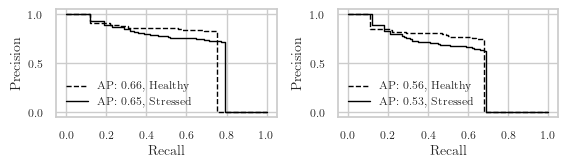

In [40]:
fig_save_dir = '../../thesis/graphics/'

fig, ax = plt.subplots(1, 2, figsize=set_size(width, subplots=(1,2)))
results.plot_pr_curves(classes=classes, iou_thresh=0.5, backend='matplotlib', ax=ax[0], color='black', linewidth=1)
results.plot_pr_curves(classes=classes, iou_thresh=0.95, backend='matplotlib', ax=ax[1], color='black', linewidth=1)
# Set the labels for the legends manually
ax[0].get_lines()[0].set_linestyle('dashed')
ax[1].get_lines()[0].set_linestyle('dashed')
ax[0].legend(['AP: 0.66, Healthy', 'AP: 0.65, Stressed'], frameon=False)
ax[1].legend(['AP: 0.56, Healthy', 'AP: 0.53, Stressed'], frameon=False)
fig.tight_layout()
fig.savefig(fig_save_dir + 'APmodel.pdf', format='pdf', bbox_inches='tight')

The confusion matrix for the aggregate model seems to not show the cases where the object detection was successful but the class was wrong. For example, in the matrix below all classifications were correct or the detection failed. Under column _Stressed_ and row _Healthy_ not a single item is recorded. It seems that this evaluation metric does not have as much relevance when compared to the AP curves above or the mAP values.

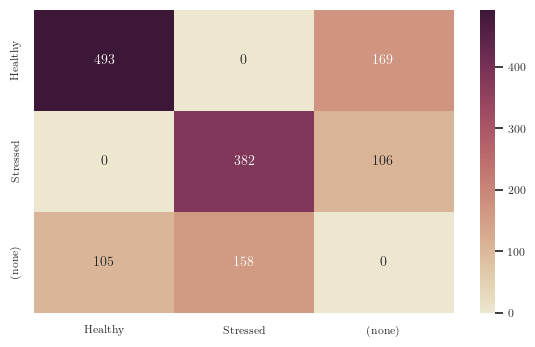

In [11]:
import numpy as np
fig, ax = plt.subplots(1, 1, figsize=set_size(width, subplots=(1,1)))
# Manually set confusion matrix values obtained from results.plot_confusion_matrix()
matrix = np.array([[493, 0, 169], [0, 382, 106], [105, 158, 0]])
labels = ['Healthy', 'Stressed', '(none)']
sns.heatmap(matrix, annot=True, xticklabels=labels, yticklabels=labels, fmt=".0f", cmap=sns.cubehelix_palette(as_cmap=True, start=.3, hue=1, light=.9))
fig.tight_layout()
fig.savefig(fig_save_dir + 'CMmodel.pdf', format='pdf', bbox_inches='tight')

### View dataset in fiftyone <a name="modelfiftyonesession"></a>

We can launch a fiftyone session in a new tab to explore the dataset and the results.

In [101]:
session = fo.launch_app(dataset, auto=False)
session.view = dataset.view()
session.open_tab()

Session launched. Run `session.show()` to open the App in a cell output.


<IPython.core.display.Javascript object>

In [104]:
session.close()